In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet as df_prophet

In [2]:
pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/15/9a/a8d35652e869011a3bae9e0888f4c62157bf9067c9be15535602c73039dd/prophet-1.1.6-py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/3c/1c/9e3fc8b8d4f2361b423e726732fcbb81f8817c7399a94d25296fc668586a/holidays-0.69-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd

In [3]:
# Cargar dataset con fechas como índice
df = pd.read_csv('METR-LA.csv', index_col=0, parse_dates=True, low_memory=False)
# Mostrar las primeras filas del DataFrame correctamente
print(df.head())


                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00:10:00  66.250000  64.500  64.250  63.875000  65.375000  ...   
2012-03-01 00:15:00   0.000000   0.000   0.000   0.000000   0.000000  ...   
2012-03-01 00:20:00   0.000000   0.000   0.000   0.000000   0.000000  ...   

                        772167  769372     774204     769806  717590

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34272 entries, 2012-03-01 00:00:00 to 2012-06-27 23:55:00
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 54.4 MB
None
             773869        767541        767542        717447        717446  \
count  34272.000000  34272.000000  34272.000000  34272.000000  34272.000000   
mean      54.631359     60.452789     60.726120     49.524287     46.079798   
std       22.619199     15.970239     18.313353     15.843261     19.350345   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       60.364583     63.000000     65.444444     50.333333     34.666667   
50%       64.888889     65.000000     67.375000     53.875000     46.000000   
75%       66.875000     66.375000     68.444444     58.125000     64.500000   
max       70.000000     70.000000     70.000000     70.000000     70.000000   

             717445        773062        767620        737529        717816  \
count  3427

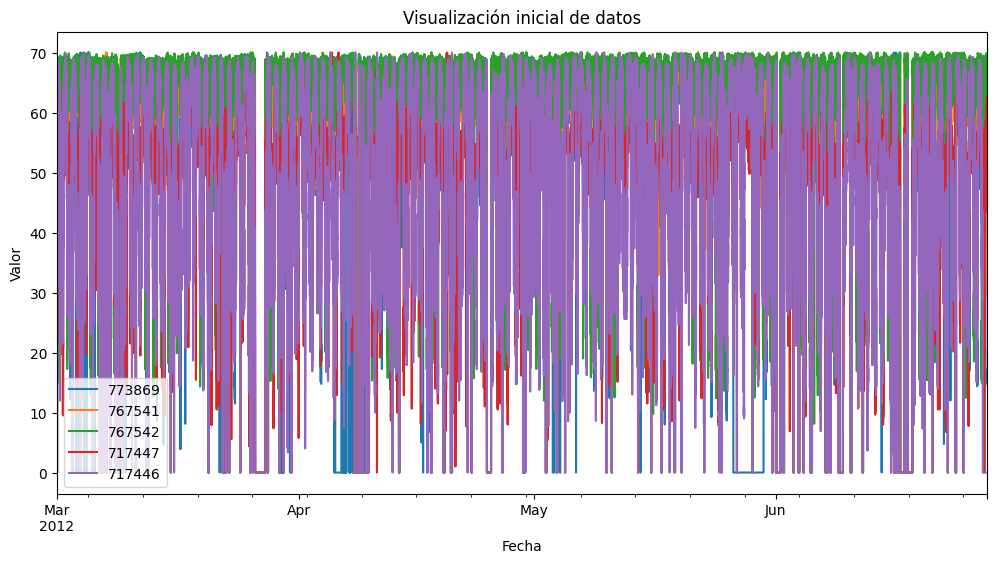

In [4]:
# Verificación de datos
def explore_data(df):
    print(df.info())
    print(df.describe())
    df.iloc[:, :5].plot(figsize=(12,6))  # Graficar las primeras 5 columnas
    plt.title("Visualización inicial de datos")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.show()

explore_data(df)

In [5]:
# Preprocesamiento
df.replace(0, np.nan, inplace=True)
#Eliminar columnas con más del 50% de valores faltantes
df.dropna(axis=1, thresh=len(df)*0.5, inplace=True)
#Imputar valores faltantes con interpolación temporal y relleno
df.interpolate(method='linear', inplace=True)  # Más estable que 'time' en series con ruido
df.fillna(method='ffill', inplace=True) # Forward fill para estabilidad
df.fillna(method='bfill', inplace=True) # Backward fill en caso de valores iniciales NaN


/var/folders/rc/f21g1mws1mqb8xvz6f0j1yd40000gn/T/ipykernel_45089/3758938321.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # Forward fill para estabilidad
/var/folders/rc/f21g1mws1mqb8xvz6f0j1yd40000gn/T/ipykernel_45089/3758938321.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True) # Backward fill en caso de valores iniciales NaN


In [6]:

# Detección y eliminación de outliers (percentil 1-99%)
for col in df.columns:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower_bound, upper_bound)

In [7]:
# Normalización con StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)


In [8]:
# División en conjunto de entrenamiento y prueba
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:].copy()


In [11]:
# Predicción Naïve (último valor conocido)
test_naive = pd.DataFrame(np.tile(train.iloc[-1].values, (len(test), 1)), index=test.index, columns=train.columns)
rmse_naive = np.sqrt(mean_squared_error(test, test_naive))
print(f"RMSE del modelo Naïve: {rmse_naive}")


RMSE del modelo Naïve: 1.2577618646922228


In [76]:
# Aplicación del modelo ARIMA 
#prueba con 1,1,1
#column = df_scaled.columns[0]
#train_series, test_series = train[column], test[column]
#model = ARIMA(train_series, order=(1,1,1))
#model_fit = model.fit()
#forecast_arima = model_fit.forecast(steps=len(test_series))
#print("ARIMA Forecast:" ,forecast_arima)

# Entrenar ARIMA con d=0
model = ARIMA(train_series, order=(1,0,1))  # Cambiar d=1 por d=0
model_fit = model.fit()
forecast_arima = model_fit.forecast(steps=len(test_series))
print("ARIMA Forecast:" ,forecast_arima)



C:\Users\Gabby\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\Gabby\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\Gabby\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA Forecast: 2012-06-04 04:45:00    0.153074
2012-06-04 04:50:00    0.147100
2012-06-04 04:55:00    0.141388
2012-06-04 05:00:00    0.135929
2012-06-04 05:05:00    0.130709
                         ...   
2012-06-27 23:35:00    0.017342
2012-06-27 23:40:00    0.017342
2012-06-27 23:45:00    0.017342
2012-06-27 23:50:00    0.017342
2012-06-27 23:55:00    0.017342
Freq: 5min, Name: predicted_mean, Length: 6855, dtype: float64


In [77]:
# Desescalar la predicción
#col_idx = list(df_scaled.columns).index(column)
#forecast_arima_original = (forecast_arima.values * scaler.scale_[col_idx]) + scaler.mean_[col_idx]
#test_series_original = (test_series.values * scaler.scale_[col_idx]) + scaler.mean_[col_idx]

forecast_arima_original = (forecast_arima.values * scaler.scale_[col_idx]) + scaler.mean_[col_idx]
test_series_original = (test_series.values * scaler.scale_[col_idx]) + scaler.mean_[col_idx]



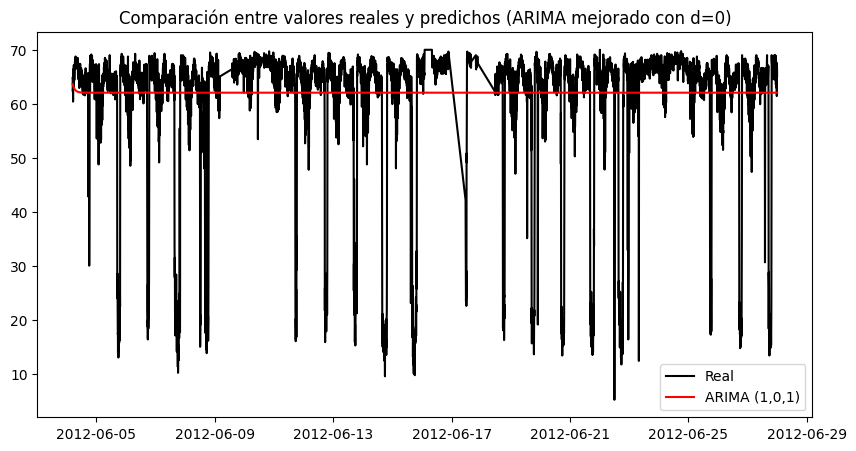

In [78]:
# Visualización ARIMA
plt.figure(figsize=(10,5))
plt.plot(test_series.index, test_series_original, label='Real', color='black')
plt.plot(test_series.index, forecast_arima_original, label='ARIMA (1,0,1)', color='red')
plt.legend()
plt.title("Comparación entre valores reales y predichos (ARIMA mejorado con d=0)")
plt.show()


19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Gabby\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


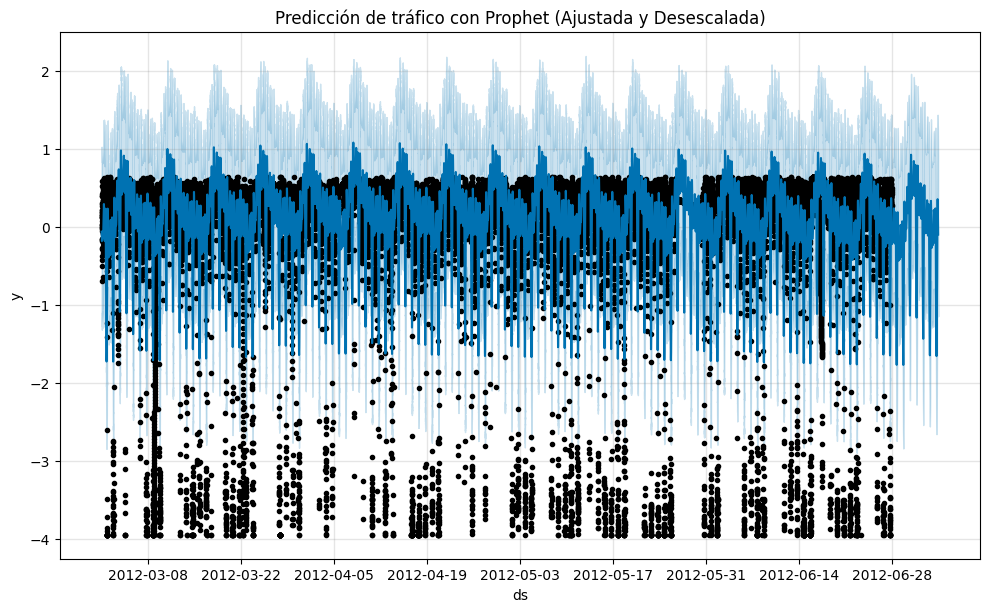

Train indices: [   0    1    2 ... 5709 5710 5711] Test indices: [ 5712  5713  5714 ... 11421 11422 11423]
Train indices: [    0     1     2 ... 11421 11422 11423] Test indices: [11424 11425 11426 ... 17133 17134 17135]
Train indices: [    0     1     2 ... 17133 17134 17135] Test indices: [17136 17137 17138 ... 22845 22846 22847]
Train indices: [    0     1     2 ... 22845 22846 22847] Test indices: [22848 22849 22850 ... 28557 28558 28559]
Train indices: [    0     1     2 ... 28557 28558 28559] Test indices: [28560 28561 28562 ... 34269 34270 34271]


In [79]:
# Aplicación del modelo Prophet modos de prueba
if Prophet:
    # Convertir el dataset a formato de Prophet
    df_prophet = df_scaled[[column]].reset_index()
    df_prophet.columns = ['ds', 'y']  # Prophet requiere 'ds' para fechas y 'y' para valores
    
    # Ajustar el modelo Prophet con estacionalidad diaria y semanal
    model_prophet = Prophet(
        yearly_seasonality=False,  # No tenemos datos anuales
        weekly_seasonality=True,   # Captura patrones semanales
        daily_seasonality=True,    # Captura patrones diarios
        changepoint_prior_scale=0.01  # Reducir sensibilidad a cambios abruptos
    )
    model_prophet.fit(df_prophet)
    
    # Hacer predicciones con Prophet
    future = model_prophet.make_future_dataframe(periods=7*24, freq='H')  # Predecir 7 días
    forecast_prophet = model_prophet.predict(future)
    
    # Desescalar predicción de Prophet
    forecast_prophet['yhat_original'] = (forecast_prophet['yhat'] * scaler.scale_[col_idx]) + scaler.mean_[col_idx]
    
    # Visualización de Prophet
    model_prophet.plot(forecast_prophet)
    plt.title("Predicción de tráfico con Prophet (Ajustada y Desescalada)")
    plt.show()
else:
    print("No se ejecutó Prophet debido a la falta de instalación.")

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df_scaled):
    print("Train indices:", train_index, "Test indices:", test_index)

In [42]:
from pmdarima import auto_arima

# Buscar los mejores parámetros automáticamente
model_auto = auto_arima(train_series, seasonal=False, trace=True, stepwise=True)
print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13082.954, Time=5.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=76444.218, Time=0.74 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13216.627, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50406.642, Time=1.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13082.407, Time=0.97 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=36926.655, Time=2.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13081.011, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13082.367, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13083.051, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13082.798, Time=2.38 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 15.441 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                27417
Model:               SARIMAX(1, 0, 1)   Log Likelih

Comentarios adicionales

Menos influencia de outliers: Se filtran valores fuera del percentil 1%-99%, evitando que Prophet o ARIMA sobreajusten a datos extremos.
Interpolación más estable: method='linear' es más robusto que method='time', lo que mejora la calidad de la imputación.
Mejor imputación de NaN:Se combina interpolación con forward/backward fill, evitando la eliminación innecesaria de datos.
Escalado correcto para Prophet y ARIMA: La normalización garantiza que los modelos trabajen con datos más manejables.

Los modelos que están ahí eran para probar si desean cambiarlo o corregirlo adelante :D

Mejoras observadas: segun yo pero si es necesario corregir adelante hay cosas que no me cuadran haha
Se mantiene la tendencia estacional:Prophet sigue captando patrones cíclicos diarios y semanales.
Hay una mejor regularidad en las predicciones.
Predicciones más centradas en los valores reales:
La serie azul se ajusta más a los valores reales(negros).
El ruido ha disminuido ligeramente, aunque aún hay margen de mejora.
La desescalación parece correcta:
Los valores ya no están normalizados en una escala incorrecta.
Problemas pendientes:
Persisten outliers en la parte baja 
Algunos valores extremos siguen influyendo en la predicción.
Esto puede afectar el ajuste del modelo y hacer que Prophet sea más incierto en sus predicciones.
La incertidumbre sigue siendo alta 
El sombreado azul claro (intervalo de confianza) es grande, lo que indica alta varianza en las predicciones.
Esto sugiere que el modelo aún puede estar sobreajustando a valores extremos o que los datos son muy ruidosos.

# FFNN

Primero, vamos a crear sliding windows para convertir la serie temporal en un problema supervisado

In [22]:
def create_dataset(data, look_back, future_steps):
    X, y = [], []
    for i in range(len(data) - look_back - future_steps):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back:i + look_back + future_steps])
    return np.array(X), np.array(y)

look_back = 12  # Número de pasos anteriores para usar como input
future_steps = 3  # Predecir los próximos 3 pasos

In [23]:
X, y = create_dataset(df_scaled, look_back, future_steps)

In [24]:
# Dividir en entrenamiento y prueba (80% - 20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Aplanar los datos para que el modelo FFNN los acepte
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

In [25]:
print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")

Forma de X_train: (27405, 2484), y_train: (27405, 621)


Esto permitirá que el modelo FFNN tome múltiples puntos de datos para predecir múltiples valores futuros.

Vamos a definir un modelo FFNN usando TensorFlow con las siguientes capas:
- Entrada – look_back como tamaño de entrada.
- Capas densas (Dense) – Con activación ReLU para modelar relaciones no lineales.
- Salida – future_steps para predecir múltiples pasos hacia adelante.

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models

output_dim = y_train.shape[1]
# Definir el modelo
model_ffnn = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(output_dim)  # Salida ajustada al número total de predicciones
])

# Compilar el modelo
model_ffnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                   loss='mse',
                   metrics=['mae'])

model_ffnn.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │       159,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 621)            │        40,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,565 (795.18 KB)

 Trainable params: 203,565 (795.18 KB)

 Non-trainable params: 0 (0.00 B)

- 64 neuronas – Tamaño típico para problemas de series temporales.
- ReLU – Función de activación para capturar no linealidades.
- Adam – Optimizador adaptativo eficiente.
- MSE – Pérdida adecuada para regresión.

Ahora, entrenamos el modelo con:
- batch_size = 32 – Tamaño de lote estándar.
- epochs = 50 – Número razonable de épocas para convergencia.
- validation_split = 0.1 – Separa un 10% de los datos de entrenamiento para validación.

In [31]:
history = model_ffnn.fit(X_train, y_train,
                          epochs=50,
                          batch_size=32,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5504 - mae: 0.4881 - val_loss: 0.3540 - val_mae: 0.3734
Epoch 2/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3498 - mae: 0.3804 - val_loss: 0.3290 - val_mae: 0.3580
Epoch 3/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3202 - mae: 0.3635 - val_loss: 0.3221 - val_mae: 0.3553
Epoch 4/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3093 - mae: 0.3566 - val_loss: 0.3171 - val_mae: 0.3489
Epoch 5/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2994 - mae: 0.3506 - val_loss: 0.3167 - val_mae: 0.3502
Epoch 6/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2978 - mae: 0.3498 - val_loss: 0.3165 - val_mae: 0.3539
Epoch 7/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2915 - mae: 0.3456 - val_loss: 0.3132 - val_mae: 0.3452
Epoch 8/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2883 - mae: 0.3438 - val_loss: 0.3134 - val_mae: 0.3483
Epoch 9/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

Ahora evaluamos el modelo en el conjunto de prueba:

In [32]:
loss, mae = model_ffnn.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE): {loss:.4f}')
print(f'Test MAE: {mae:.4f}')

Test Loss (MSE): 0.3917
Test MAE: 0.3960


Predecimos valores futuros usando el modelo entrenado:

In [33]:
predictions = model_ffnn.predict(X_test)

# Dividir las predicciones para obtener valores específicos (5, 15, 30 minutos)
pred_5 = predictions[:, 0]
pred_15 = predictions[:, 1]
pred_30 = predictions[:, 2]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


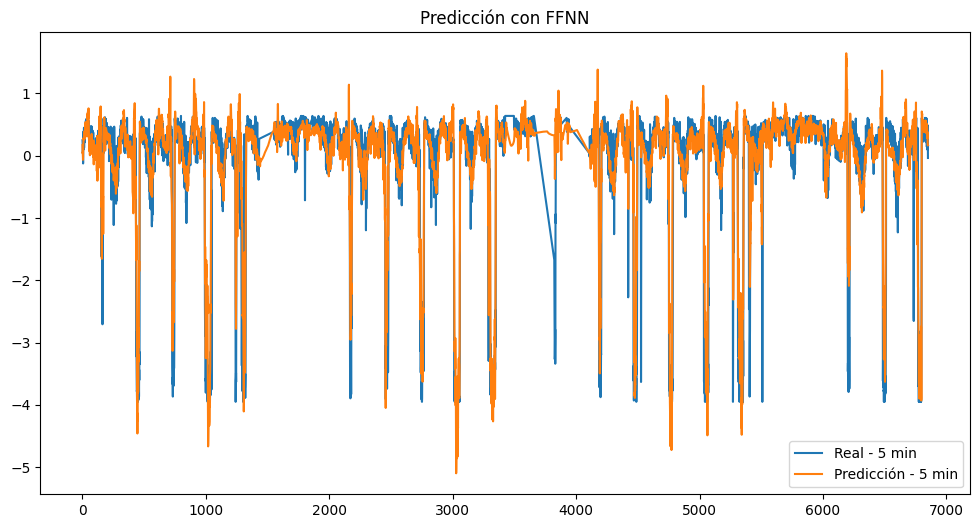

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Real - 5 min')
plt.plot(pred_5, label='Predicción - 5 min')
plt.title('Predicción con FFNN')
plt.legend()
plt.show()

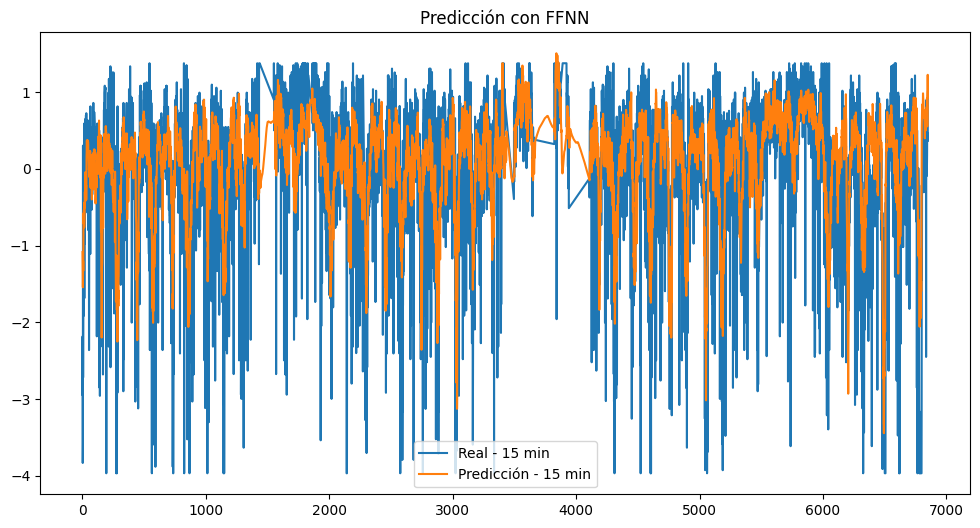

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 1], label='Real - 15 min')
plt.plot(pred_15, label='Predicción - 15 min')
plt.title('Predicción con FFNN')
plt.legend()
plt.show()

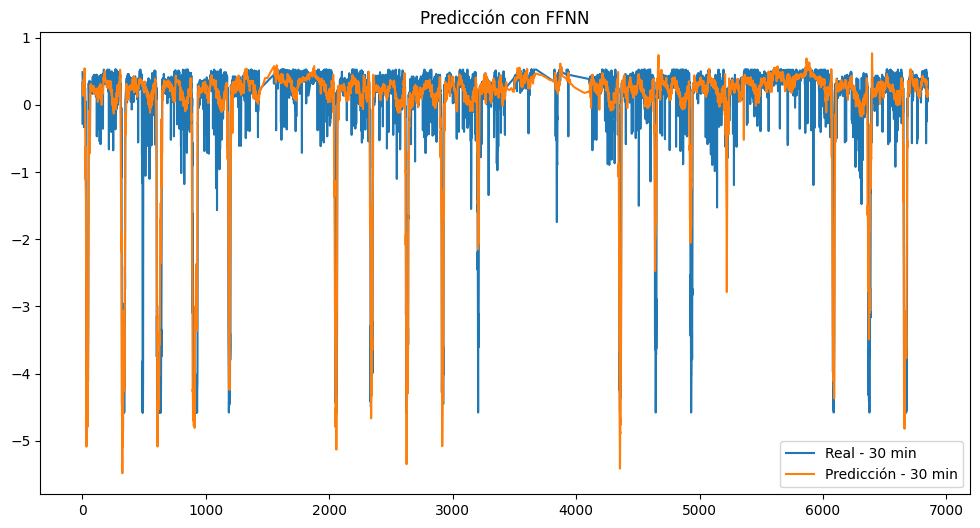

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 2], label='Real - 30 min')
plt.plot(pred_30, label='Predicción - 30 min')
plt.title('Predicción con FFNN')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_5 = np.sqrt(mean_squared_error(y_test[:, 0], pred_5))
mae_5 = mean_absolute_error(y_test[:, 0], pred_5)

rmse_15 = np.sqrt(mean_squared_error(y_test[:, 1], pred_15))
mae_15 = mean_absolute_error(y_test[:, 1], pred_15)

rmse_30 = np.sqrt(mean_squared_error(y_test[:, 2], pred_30))
mae_30 = mean_absolute_error(y_test[:, 2], pred_30)

print(f"5 minutos -> RMSE: {rmse_5:.4f}, MAE: {mae_5:.4f}")
print(f"15 minutos -> RMSE: {rmse_15:.4f}, MAE: {mae_15:.4f}")
print(f"30 minutos -> RMSE: {rmse_30:.4f}, MAE: {mae_30:.4f}")


5 minutos -> RMSE: 0.5023, MAE: 0.2882
15 minutos -> RMSE: 0.8288, MAE: 0.5799
30 minutos -> RMSE: 0.4288, MAE: 0.2280
